In [79]:
from src.data import gedi_pipeline
import math

import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
import matplotlib.pyplot as plt
palette = sns.color_palette("Set2")

sns.set_theme()

In [2]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_11()

In [86]:
gedi_unburned = gedi_unburned[gedi_unburned.dw_land_cover_std == 0]

In [88]:
gedi_unburned["dw_land_cover"] = gedi_unburned.dw_land_cover_median

In [93]:
# 1 = trees
# 2 = grass
# 4 = crops
# 5 = shrub_and_scrub
# 6 = built
# 7 = bare
# 8 = snow_and_ice
# Keep only trees and shrubs
gedi_unburned = gedi_unburned[gedi_unburned.dw_land_cover.isin([1, 2, 5])]

<AxesSubplot: xlabel='dw_land_cover', ylabel='Count'>

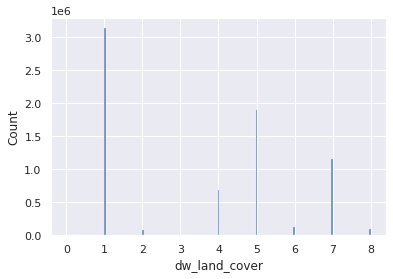

In [91]:
sns.histplot(gedi_unburned, x="dw_land_cover")

In [70]:
def calculate_agbd_from_rh_metrics(rh70, rh98):
    return 1.013 * ((
        -114.366 + 
        8.401 * math.sqrt(rh70 + 100) + 
        3.346 * math.sqrt(rh98 + 100)
        ) ** 2)

In [76]:
test_ent = gedi_unburned[gedi_unburned.gridded_pft_class == 1].sample(100000)[["agbd", "rh_70", "rh_98", "gridded_pft_class"]]
test_grass = gedi_unburned[gedi_unburned.gridded_pft_class == 6].head(100)[["agbd", "rh_70", "rh_98", "gridded_pft_class"]]

In [77]:
test_ent["new_agbd"] = test_ent.apply(lambda x: calculate_agbd_from_rh_metrics(x["rh_70"], x["rh_98"]), axis=1)

In [78]:
print((test_ent.agbd - test_ent.new_agbd).max())
print((test_ent.agbd - test_ent.new_agbd).min())

0.1201709798751267
-0.4291088992595178


3137280 323680


<AxesSubplot: xlabel='gridded_pft_class', ylabel='rh_98'>

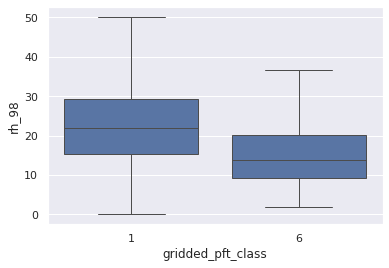

In [100]:
df = gedi_unburned[gedi_unburned.dw_land_cover == 1]
print(len(df), len(df[df.gridded_pft_class == 6]))
sns.boxplot(df[df.gridded_pft_class.isin([1, 6])], x="gridded_pft_class", y="rh_98", showfliers=False)

77185 53347


<AxesSubplot: xlabel='gridded_pft_class', ylabel='rh_98'>

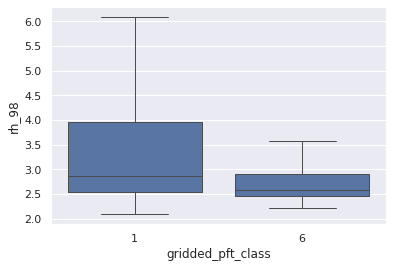

In [101]:
df = gedi_unburned[gedi_unburned.dw_land_cover == 2]
print(len(df), len(df[df.gridded_pft_class == 6]))
sns.boxplot(df[df.gridded_pft_class.isin([1, 6])], x="gridded_pft_class", y="rh_98", showfliers=False)

1901992 1199052


<AxesSubplot: xlabel='gridded_pft_class', ylabel='rh_98'>

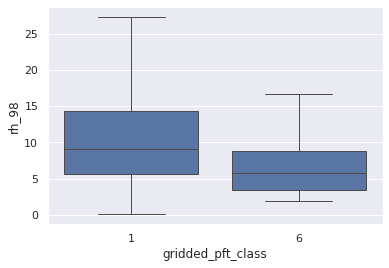

In [102]:
df = gedi_unburned[gedi_unburned.dw_land_cover == 5]
print(len(df), len(df[df.gridded_pft_class == 6]))
sns.boxplot(df[df.gridded_pft_class.isin([1, 6])], x="gridded_pft_class", y="rh_98", showfliers=False)

### Filtering unburned

Based on the plots above, to be conservative, we will keep all unburned regions that are classified as trees by the dynamic world land cover product. Then, among those, all the ones that use pft class for grass - about 300,000 of them, we will recalculate AGBD for.

In [103]:
gedi_unburned = gedi_unburned[gedi_unburned.dw_land_cover_median == 1]

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

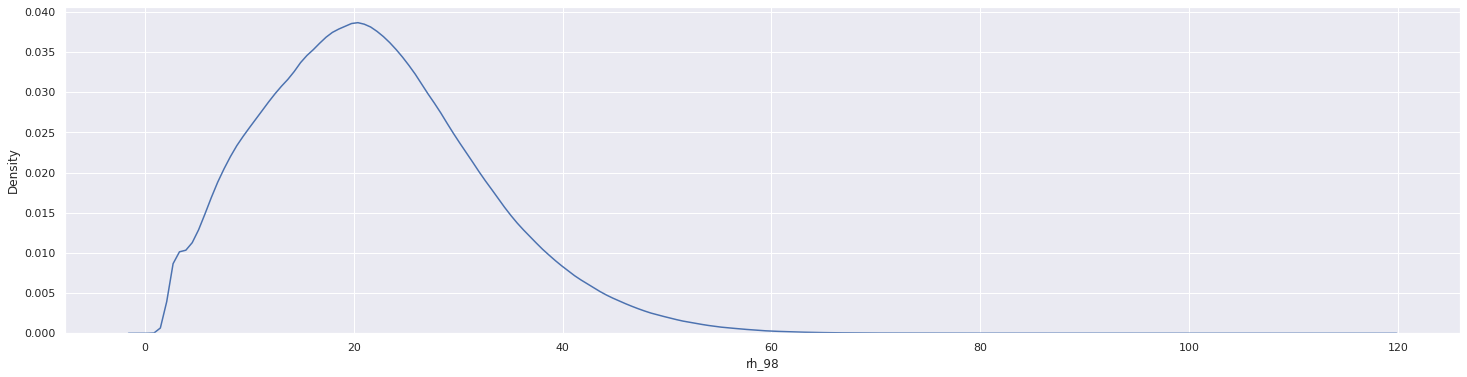

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.kdeplot(gedi_unburned, x="rh_98")

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

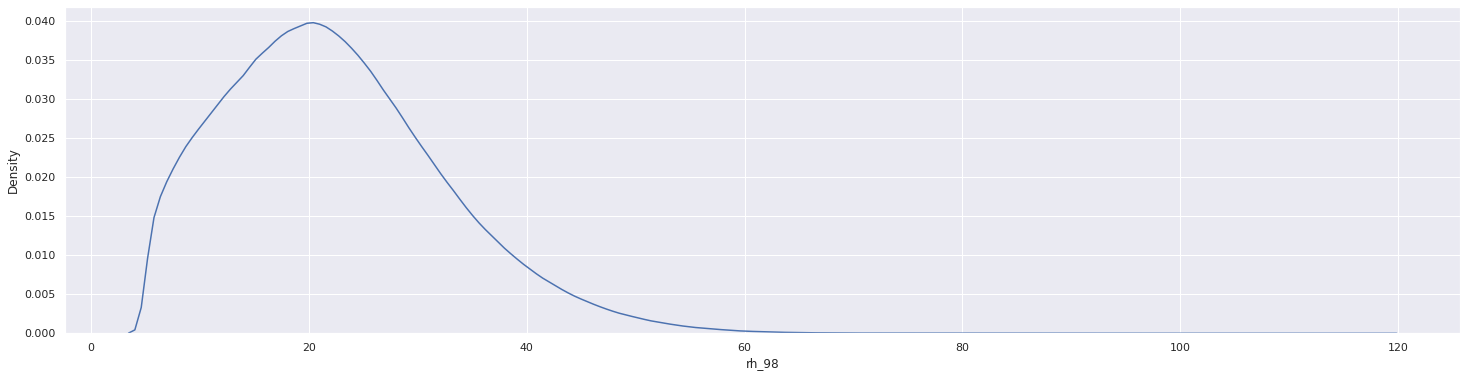

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.kdeplot(gedi_unburned[gedi_unburned.rh_98 > 5], x="rh_98")

In [105]:
ent = gedi_unburned[gedi_unburned.gridded_pft_class == 1]
gsw = gedi_unburned[gedi_unburned.gridded_pft_class == 6]
print(len(ent), len(gsw))

2761224 323680


In [113]:
gsw["new_agbd"] = gsw.apply(lambda x: calculate_agbd_from_rh_metrics(x["rh_70"], x["rh_98"]), axis=1)
gsw["agbd_diff"] = gsw.new_agbd - gsw.agbd

(0.0, 500.0)

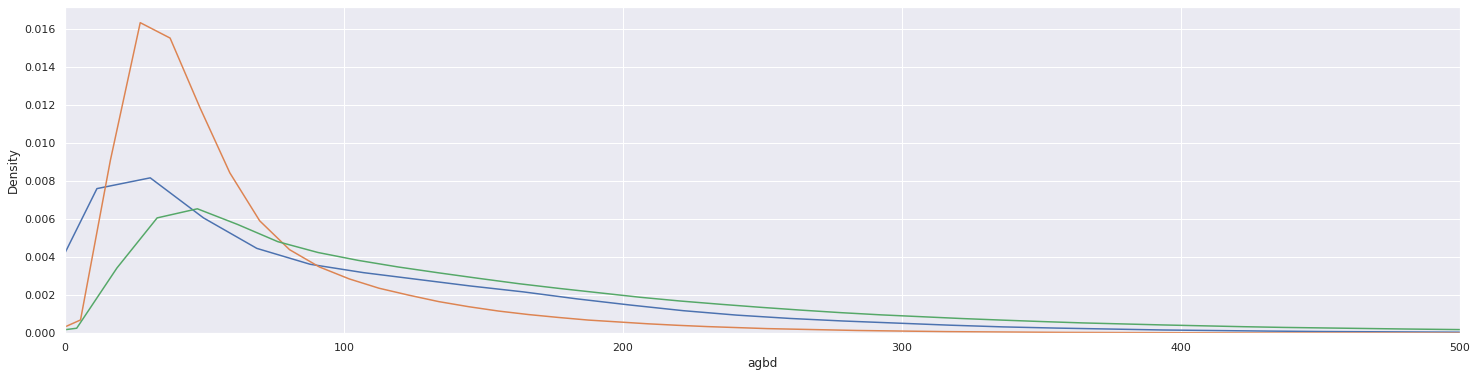

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.kdeplot(gsw[gsw.rh_98 > 5], x="agbd")
sns.kdeplot(gsw[gsw.rh_98 > 5], x="new_agbd")
sns.kdeplot(ent[ent.rh_98 > 5], x="agbd")
ax.set_xlim((0, 500))

(0.0, 500.0)

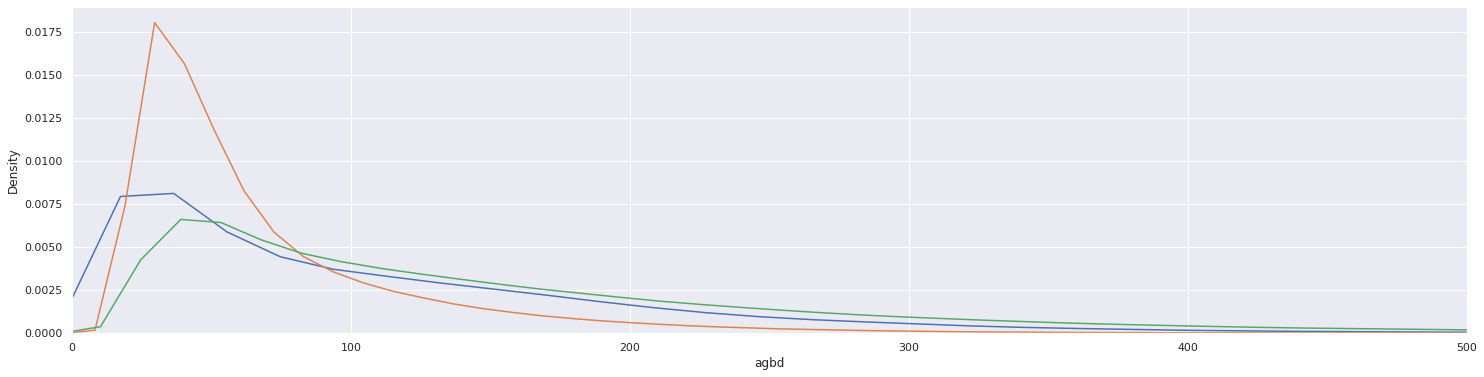

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.kdeplot(gsw[gsw.rh_98 > 5], x="agbd")
sns.kdeplot(gsw[gsw.rh_98 > 5], x="new_agbd")
sns.kdeplot(ent[ent.rh_98 > 5], x="agbd")
ax.set_xlim((0, 500))

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

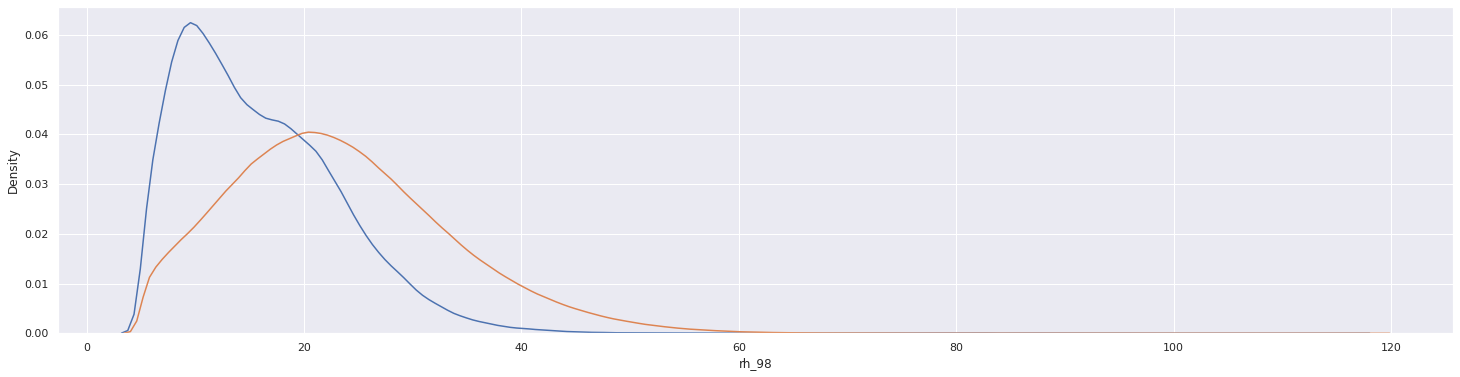

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.kdeplot(gsw[gsw.rh_98 > 5], x="rh_98")
sns.kdeplot(ent[ent.rh_98 > 5], x="rh_98")

<AxesSubplot: xlabel='rh_70', ylabel='Density'>

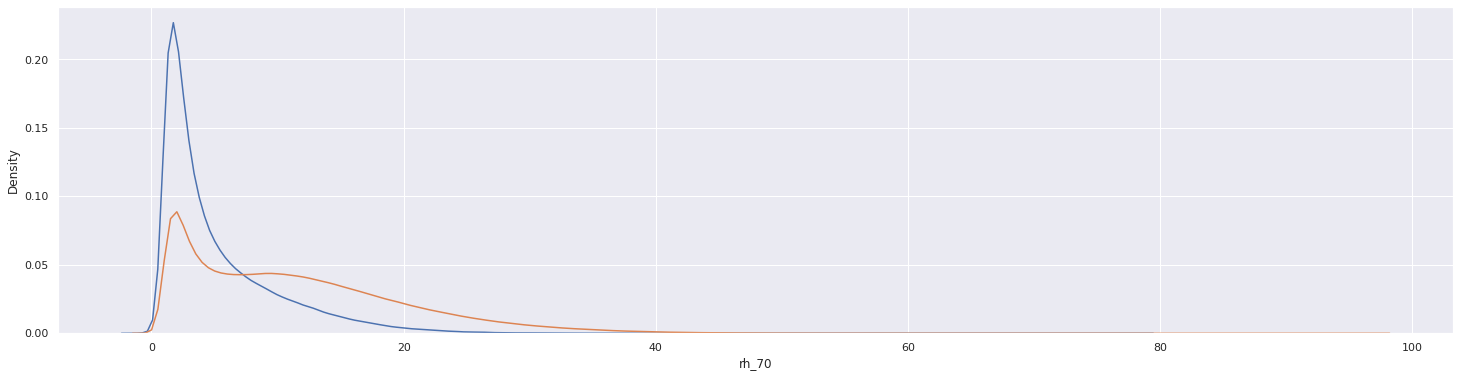

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.kdeplot(gsw[gsw.rh_98 > 5], x="rh_70")
sns.kdeplot(ent[ent.rh_98 > 5], x="rh_70")

(0.0, 500.0)

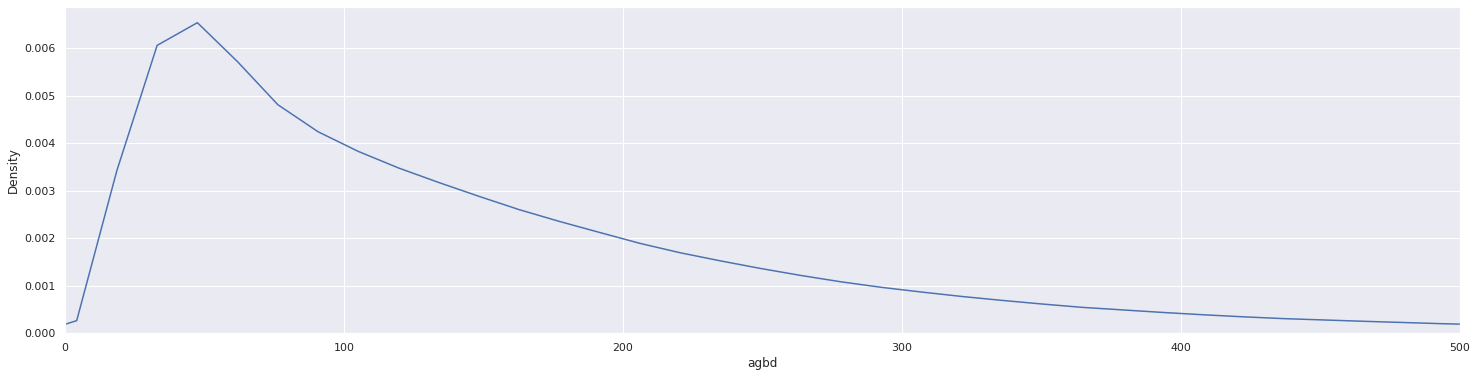

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.kdeplot(ent, x="agbd")
ax.set_xlim((0, 500))

In [ ]:
sns.boxplot(gedi_unburned[gedi_unburned.gridded_pft_class.isin([1, 6])], x="gridded_pft_class", y="rh_98", showfliers=False)

In [14]:
test_ent[["agbd", "rh_70", "rh_98", "gridded_pft_class"]]

,agbd,rh_70,rh_98,gridded_pft_class
237,88.746674,7.58,19.549999,1
277,41.054451,2.88,12.660000,1
278,59.912258,4.86,15.910000,1
838,151.799438,13.18,23.790001,1
839,57.812351,3.46,18.760000,1
840,19.101706,0.96,5.020000,1
841,72.184921,6.25,17.090000,1
842,21.103428,1.30,5.510000,1
845,41.380116,2.38,14.140000,1
848,65.906662,3.83,21.110001,1


In [11]:
# Grass - 6, ENT - 1
calculate_agbd_from_rh_metrics(7.58, 19.549999)

88.85531699608794

In [12]:
calculate_agbd_from_rh_metrics(2.28, 7.590000)

28.60464262795253